In [1]:
from train_pointnet import LitModel1
from dataset.shapenet import ShapeNetPart
from torch.utils.data import DataLoader
from einops import rearrange
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [85]:
net = LitModel1.load_from_checkpoint("wandb/hyperbolic/gikansi5/checkpoints/last.ckpt").to(torch.device("cpu"))

In [86]:
mlr = net.net.mlr
pts = mlr.points.detach()
pts.shape

torch.Size([66, 2])

In [87]:
mlr.signed

True

In [88]:
n_cls = len(net.clss)
n_inst = len(net.insts)
net.clss, net.insts, n_cls, n_inst

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 16,
 50)

In [92]:
plt.rcParams["figure.figsize"] = (5,5)

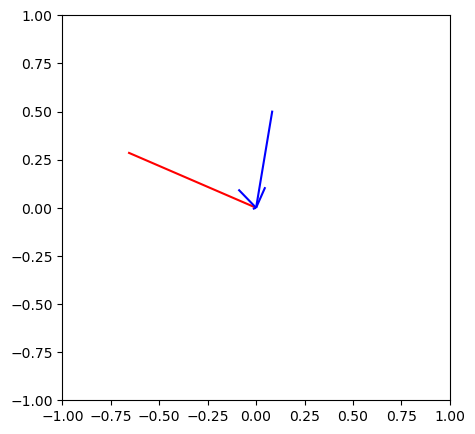

In [94]:
def plt_gyroplanes(ax, pts, dirs, c, color="blue"):   
    # sampling dir
    N = 1000
    B = pts.shape[0]
    vecs = torch.randn((N,2))
    # shift them around dirs
    vec1 = torch.stack([-dirs[:,1], dirs[:,0], torch.zeros((B,))],dim=-1) # B,2
    vec2 = torch.stack([-dirs[:,2], torch.zeros((B,)), dirs[:,0]],dim=-1) # B,3
    vecs = vec1[None,:,:]*vecs[:,None,:1] + vec2[None,:,:]*vecs[:,None,1:] # N,B,3
    
    inhyp = mlr.ball.expmap(pts, vecs)
    r = c.pow(-1).sqrt()
    
    origins = torch.zeros_like(pts)

    lines = torch.stack([origins, pts], dim=-2)

    coll = LineCollection(lines, colors=color)
    ax.add_collection(coll)
    
    for i in range(B):
        print(i)
        print(pts[i])
        print(dirs[i])
        ax.scatter(inhyp[:,i,0], inhyp[:,i,1], inhyp[:,i,2], s=2)
    
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    ax.set_zlim(-r, r)
    

def plt_points(ax, pts, c, color="blue"):
    origins = torch.zeros_like(pts)

    lines = torch.stack([origins, pts], dim=-2)

    coll = LineCollection(lines, colors=color)

    r = c.pow(-1).sqrt() # c|x|² < 1 => |x| < sqrt(1/c)

    #ax.scatter(pts[:,0,:], pts[:,1], pts[:,2])
    ax.add_collection(coll)

    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    
ax = plt.figure().add_subplot()  

CLS = 0

ps_i = [n_cls + p for p in ShapeNetPart.cls2parts[CLS]]
plt_points(ax, pts[[CLS]], mlr.ball.c, color="red")
plt_points(ax, pts[ps_i], mlr.ball.c)
plt.show()

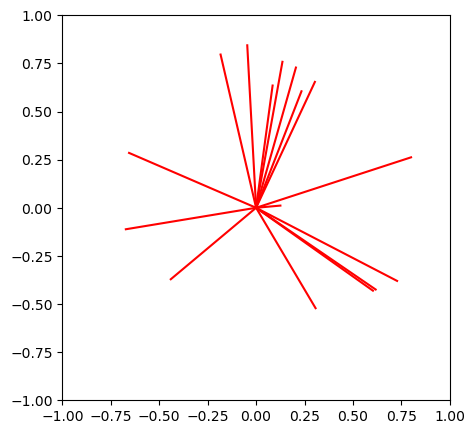

In [96]:
plt_points(plt.figure().add_subplot(), pts[:n_cls], mlr.ball.c, color="red")

In [97]:
H = net.hparams
if n_cls == 16:
    class_choice=None
else:
    class_choice = [net.clss[0]]
val_data = DataLoader(ShapeNetPart(n_points=H.n_points, partition='test', class_choice=class_choice), batch_size=100, num_workers=4, shuffle=False, pin_memory=True)
val_data_iter = iter(val_data)
x,cls,y = next(val_data_iter)
x = rearrange(x, 'b n d -> b d n')

In [98]:
mlr_inputs = net.net.net(x).detach()
mlr_inputs = mlr_inputs.permute(0,2,1)
logits = net(x).detach()
adj_logits = net.adjust_logits2(logits)

In [99]:
def calc_class_loss(logits, cls):
    logits = net.adjust_logits2(logits)
    B,C,PT = logits.shape
    logits = logits - logits.max(dim=1, keepdim=True)[0] # B,C,PT - B,C,PT => broadcast to B,C,PT - B,C,PT
    n_cls = len(net.clss)
    logits_cls = torch.zeros((B, len(net.clss), PT)).to(logits.device)
    for i,cls_i in enumerate(net.clss):
        ps_i = torch.tensor(ShapeNetPart.cls2parts[cls_i]).to(logits.device)
        logit = logits[:,ps_i,:].exp().sum(dim=1).clamp(min=1e-15).log()
        print(logit.isinf().any())
        logits_cls[:,i,:] = logit
    # this is only sensible for all classes selected ...
    loss = torch.nn.functional.cross_entropy(logits_cls, cls.expand(-1, PT))
    return loss, logits_cls

In [100]:
def show(i):
    print("Class", cls[i].item())
    
    circle = plt.Circle((0, 0), 1/mlr.ball.c.item(), fill=False, color="b")
    plt.gca().add_artist(circle)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect("equal")
    plt.scatter(*mlr.ball.expmap0(mlr_inputs[i]).detach().T, s=1, c=y[i] / 50)

Class 12


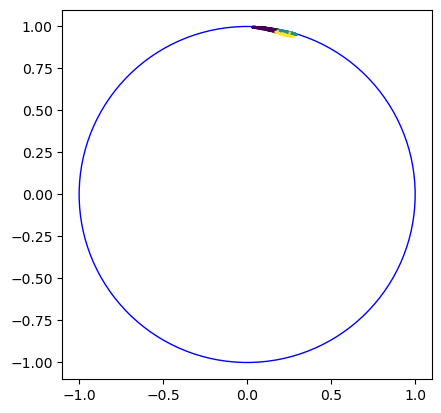

In [61]:
show(15)

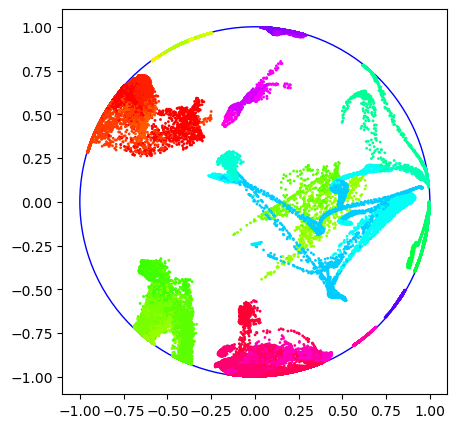

In [101]:
circle = plt.Circle((0, 0), 1/mlr.ball.c.item(), fill=False, color="b")
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
for i in range(len(mlr_inputs)):
    #print(set((y[i] / 50).tolist()))
    plt.scatter(*mlr.ball.expmap0(mlr_inputs[i]).detach().T, s=1, c=y[i] / n_inst, cmap="hsv", vmin=0, vmax=1)
#plt.colorbar()
plt.show()

CLASSES {0, 3, 4, 6, 7, 8, 11, 12, 13, 14, 15}


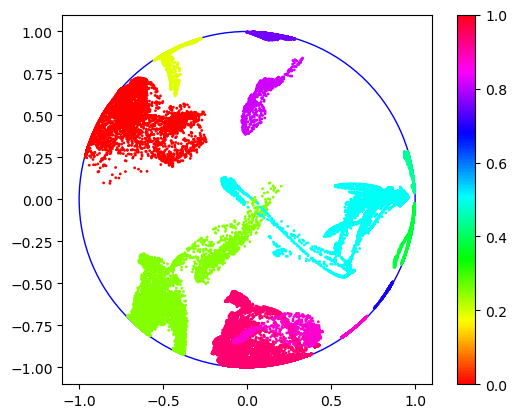

In [304]:
circle = plt.Circle((0, 0), 1/mlr.ball.c.item(), fill=False, color="b")
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
print("CLASSES", set(cls.flatten().tolist()))
for i in range(len(mlr_inputs)):
    #print(set((y[i] / 50).tolist()))
    plt.scatter(*mlr.ball.expmap0(mlr_inputs[i]).detach().T, s=1, c=torch.full((1024,), (cls[i] / n_cls).item()), cmap="hsv", vmin=0, vmax=1)
plt.colorbar()
plt.show()

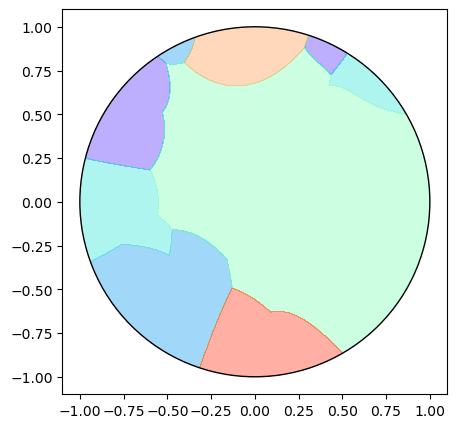

In [104]:
radius = 1/mlr.ball.c.item()
coords = torch.linspace(-radius, radius, 1000)
xx, yy = torch.meshgrid(coords, coords)
dist2 = xx ** 2 + yy ** 2
mask = dist2 > radius ** 2

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
grid = torch.stack([xx, yy], dim=-1) # 100,100,2
logits = mlr(grid).detach() # 100,100,66

logits = logits.permute(0,2,1)
if True:
    logits = net.adjust_logits2(logits) # 100,100,1
else:
    logits = logits[:,n_cls:,:]
logits = logits.permute(0,2,1)
logits = logits.argmax(dim=-1).float()
logits = logits.squeeze(dim=-1)
logits[mask] = torch.nan
#plt.scatter(*mlr.ball.expmap0(mlr_inputs[i]).detach().T, s=1, c=torch.full((1024,), (cls[i] / 16).item()), cmap="hsv", vmin=0, vmax=1)

cmap = plt.get_cmap("rainbow")

plt.contourf(
    grid[..., 0], grid[..., 1], logits / n_inst, levels=None, cmap=cmap, alpha=.4
)

origins = torch.zeros_like(pts[n_cls:])
lines = torch.stack([origins, pts[n_cls:]], dim=-2)
coll = LineCollection(lines, colors=[cmap(i / n_inst) for i in range(n_inst)])
plt.gca().add_collection(coll)
circle = plt.Circle((0, 0), radius, fill=False, color="black")
plt.gca().add_artist(circle)
plt.colorbar()
plt.show()
#print("CLASSES", set(logits.flatten().tolist()))

why is value at point not that color? => adjust_logits, but even without, why not?

RuntimeError: The expanded size of the tensor (4) must match the existing size (50) at non-singleton dimension 1.  Target sizes: [100, 4, 4].  Tensor sizes: [50, 4]

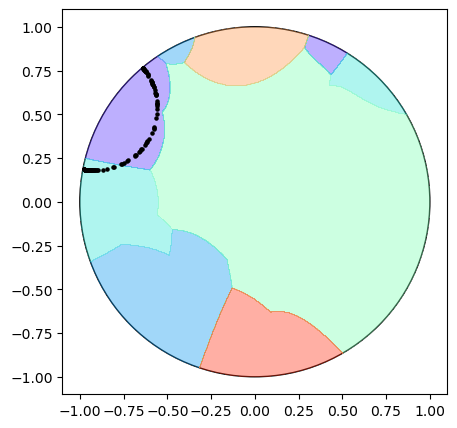

In [103]:
CLS = 0
parts = ShapeNetPart.cls2parts[CLS]
parts_t = torch.tensor(parts)

radius = 1/mlr.ball.c.item()
circle = plt.Circle((0, 0), radius, fill=False, color="black")
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")

plt.contourf(
    grid[..., 0], grid[..., 1], logits / n_inst, levels=None, cmap=cmap, alpha=.4
)

# gyroplanes
dirs = mlr.dirs.detach() # 66x2

normal_vecs = dirs[[CLS]]
normal_vecs = torch.stack([-normal_vecs[:,1], normal_vecs[:,0]], dim=-1) # P,2

#smpl = torch.empty((100, 1)).uniform_(-100, 100) # N,2
smpl = torch.randn((100,1))
line = smpl[:,None,:] * normal_vecs[None,:,:] # N,P,2

line = mlr.ball.expmap(pts[[CLS]], line.permute(1,0,2))

plt.scatter(*line.reshape(-1,2).T, s=5, c="black")

normal_vecs = dirs[n_cls+parts_t] # n_inst,2
normal_vecs = torch.stack([-normal_vecs[:,1], normal_vecs[:,0]], dim=-1) # P,2

line = smpl[:,None,:] * normal_vecs[None,:,:] # N,P,2
line = mlr.ball.expmap(pts[n_cls+parts_t][:,None,:], line.permute(1,0,2))
line = line.permute(1,0,2)
colors = torch.zeros((line.shape[0], line.shape[1],4)) # N,n_inst,4
colors[:,:,:] = torch.tensor([cmap(i / n_inst) for i in range(n_inst)])[None,:,:] # -1,n_inst
plt.scatter(*line.reshape(-1,2).T, s=5, c=colors.reshape(-1,4), alpha=.8)

# points
pt = pts[CLS]

plt.scatter(pt[None,0], pt[None,1], marker="x", color="black")
plt.scatter(pts[n_cls+parts_t,0], pts[n_cls+parts_t,1], marker="x", color=[cmap(i / n_inst) for i in range(n_inst)])

pick one gyroplane and make contourf of distance to that single line:

In [204]:
def plt_gyro(pt, dir, c, s=10):
    normal_vecs = dir[None,:] # 1,2
    normal_vecs = torch.stack([-normal_vecs[:,1], normal_vecs[:,0]], dim=-1) # P,2

    #smpl = torch.empty((100, 1)).uniform_(-100, 100) # N,2
    smpl = torch.randn((100,1)).sort(dim=0).values
    line = smpl[:,None,:] * normal_vecs[None,:,:] # N,P,2
    
    line = mlr.ball.expmap(pt[None,None,:], line.permute(1,0,2))

    plt.plot(*line.reshape(-1,2).T, c=c, linewidth=s)

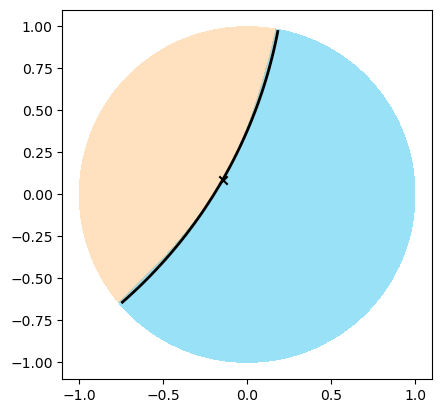

In [207]:
GYRO_IDX = 1

radius = 1/mlr.ball.c.item()
coords = torch.linspace(-radius, radius, 1000)
xx, yy = torch.meshgrid(coords, coords)
dist2 = xx ** 2 + yy ** 2
mask = dist2 > radius ** 2

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
grid = torch.stack([xx, yy], dim=-1) # 100,100,2
logits = mlr(grid).detach() # 100,100,66

y = torch.zeros_like(logits[:,:,GYRO_IDX])
y[logits[:,:,GYRO_IDX] > 0] = 1.

y[mask] = torch.nan

cmap=plt.get_cmap("rainbow")

plt.contourf(
    grid[..., 0], grid[..., 1], y, levels=1, cmap=cmap, alpha=.4
)

# gyroplanes
dirs = mlr.dirs.detach()

plt_gyro(pts[GYRO_IDX], dirs[GYRO_IDX], c="black", s=2)

#normal_vecs = dirs[[GYRO_IDX]]
#normal_vecs = torch.stack([-normal_vecs[:,1], normal_vecs[:,0]], dim=-1) # P,2

#smpl = torch.empty((100, 1)).uniform_(-100, 100) # N,2
#smpl = torch.randn((100,1))
#line = smpl[:,None,:] * normal_vecs[None,:,:] # N,P,2

#line = mlr.ball.expmap(pts[[GYRO_IDX]], line.permute(1,0,2))
#
#plt.scatter(*line.reshape(-1,2).T, s=5, c="gray")

# points
#pt = pts[[GYRO_IDX]]

plt.scatter(pt[:,0], pt[:,1], marker="x", color="black")

now try to intersecting:

tensor(-34.5388, grad_fn=<MinBackward1>) tensor(12.6820, grad_fn=<MaxBackward1>)


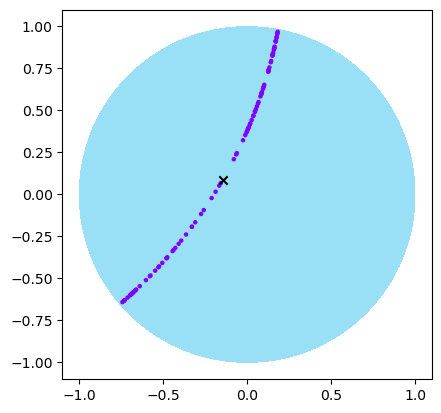

In [179]:
GYRO_IDX = [1]

radius = 1/mlr.ball.c.item()
coords = torch.linspace(-radius, radius, 1000)
xx, yy = torch.meshgrid(coords, coords)
dist2 = xx ** 2 + yy ** 2
mask = dist2 > radius ** 2

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
grid = torch.stack([xx, yy], dim=-1) # 100,100,2
logits = mlr(grid).detach() # 100,100,66

# todo: calc dist with geoopt.dist2plane

logits = mlr.ball.dist2plane(
    x=grid[:,:,None,:], p=mlr.points[None,None,:,:], a=mlr.dirs[None,None,:,:], signed=False, dim=-1
)

print(logits.min(), logits.max()) # should be 1000,1000,GYRO_IDX

logits = logits[:,:,GYRO_IDX].argmax(dim=-1).double() # i=>GYRO_IDXS[i]

logits[mask] = torch.nan

plt.contourf(
    grid[..., 0], grid[..., 1], logits / len(GYRO_IDX), levels=50, cmap=cmap, alpha=.4
)

# gyroplanes
dirs = mlr.dirs.detach()

normal_vecs = dirs[GYRO_IDX]
normal_vecs = torch.stack([-normal_vecs[:,1], normal_vecs[:,0]], dim=-1) # P,2

#smpl = torch.empty((100, 1)).uniform_(-100, 100) # N,2
smpl = torch.randn((100,1))
line = smpl[:,None,:] * normal_vecs[None,:,:] # N,P,2

line = mlr.ball.expmap(pts[GYRO_IDX][:,None,:], line.permute(1,0,2))
line = line.permute(1,0,2)

colors = torch.zeros((line.shape[0], line.shape[1],4)) # N,GYRO_IDX,4
colors[:,:,:] = torch.tensor([cmap(i / (len(GYRO_IDX)-1) if len(GYRO_IDX) > 1 else 0) for i in range(len(GYRO_IDX))])[None,:,:] # -1,GYRO_IDX,4

sc = plt.scatter(line.reshape(-1,2)[:,0], line.reshape(-1,2)[:,1], s=5, c=colors.reshape(-1,4))

# points
pt = pts[GYRO_IDX]

#plt.colorbar(sc)
plt.scatter(pt[:,0], pt[:,1], marker="x", color="black")

In [180]:
len(GYRO_IDX)

1

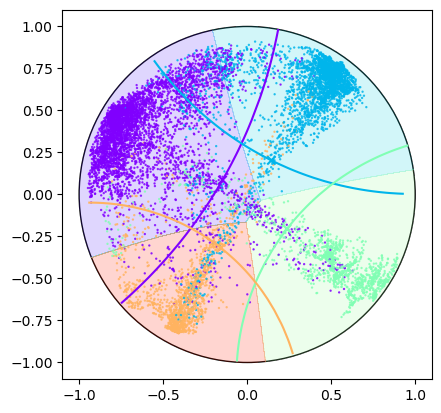

In [183]:
CLS = 0
parts = ShapeNetPart.cls2parts[CLS]
parts_t = torch.tensor(parts)

radius = 1/mlr.ball.c.item()
circle = plt.Circle((0, 0), radius, fill=False, color="black")
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")

coords = torch.linspace(-radius, radius, 1000)
xx, yy = torch.meshgrid(coords, coords)
dist2 = xx ** 2 + yy ** 2
mask = dist2 > radius ** 2

logits = mlr(grid).detach() # 100,100,66
logits = logits.permute(0,2,1)
if True:
    logits = net.adjust_logits2(logits) # 100,100,1
else:
    logits = logits[:,n_cls:,:]
logits = logits.permute(0,2,1)
logits = logits.argmax(dim=-1).float()
logits = logits.squeeze(dim=-1)
logits[mask] = torch.nan

plt.contourf(
    grid[..., 0], grid[..., 1], logits / n_inst, levels=None, cmap=cmap, alpha=.2
)

def plt_gyro(pt, dir, c):
    normal_vecs = dir[None,:] # 1,2
    normal_vecs = torch.stack([-normal_vecs[:,1], normal_vecs[:,0]], dim=-1) # P,2

    #smpl = torch.empty((100, 1)).uniform_(-100, 100) # N,2
    smpl = torch.randn((100,1)).sort(dim=0).values
    line = smpl[:,None,:] * normal_vecs[None,:,:] # N,P,2
    
    line = mlr.ball.expmap(pt[None,None,:], line.permute(1,0,2))

    plt.plot(*line.reshape(-1,2).T, c=c)

gyros = True
if gyros:
    # gyroplanes
    
    # CLS, n_cls+parts_t
    
    dirs = mlr.dirs.detach() # 66x2
    #plt_gyro(pts[CLS], dirs[CLS], "black")
    for p in n_cls+parts_t:
        plt_gyro(pts[p], dirs[p], c=cmap((p-n_cls) / n_inst))

# points
pt = pts[CLS]

plt.scatter(*mlr.ball.expmap0(mlr_inputs[::10]).detach().T, s=.5, alpha=.8, c=y[::10].T.flatten() / n_inst, cmap=cmap, vmin=0., vmax=1.)

#plt.scatter(pt[None,0], pt[None,1], marker="x", color="black")
plt.scatter(pts[n_cls+parts_t,0], pts[n_cls+parts_t,1], marker="x", color=[cmap(i / n_inst) for i in range(n_inst)])

## Log Regression

In [75]:
N = 2000
X = torch.empty((N,2)).uniform_(-3, 3)
y = torch.zeros((N,1))
y[X[:,0].sin() < X[:,1]] = 1
y[:(N//10)] = 1 - y[:(N//10)]

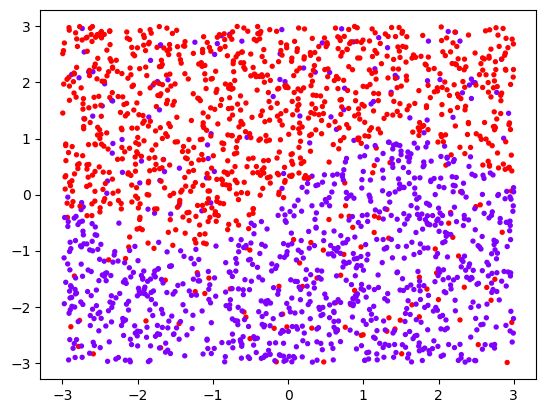

In [76]:
plt.scatter(*X.T, c=y, s=8, cmap="rainbow")

In [112]:
import sklearn.linear_model as lm
lr = lm.LogisticRegression()
lr.fit(X, y.squeeze())

LogisticRegression()

In [113]:
coords = torch.linspace(-3, 3, 100)
xx, yy = torch.meshgrid(coords, coords)
grid = torch.stack([xx, yy], dim=-1) # 100,100,2
preds = lr.predict(grid.reshape(-1,2)).reshape(grid.shape[:-1])
preds.shape

(100, 100)

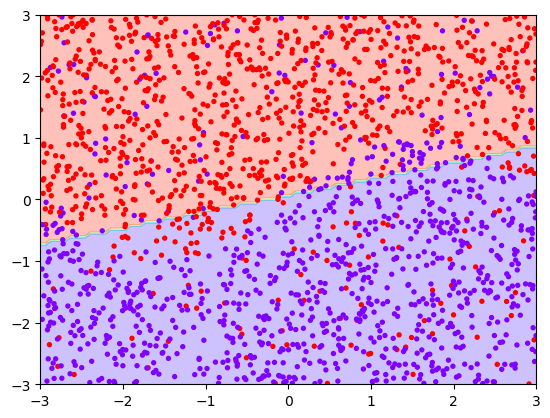

In [114]:
plt.contourf(xx, yy, preds, cmap="rainbow", alpha=.3)
plt.scatter(*X.T, c=y, s=8, cmap="rainbow")

In [111]:
lr.coef_, lr.intercept_

(array([[-0.30488392,  1.14633753]]), array([-1.76203439]))

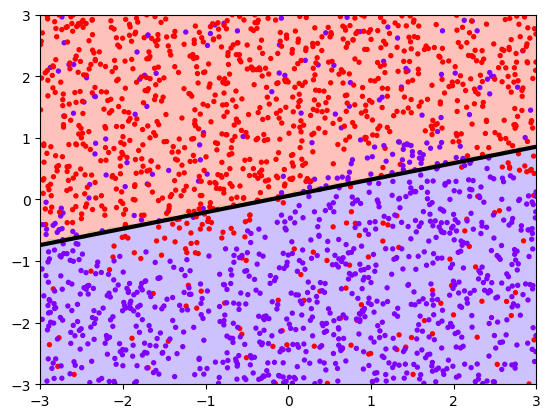

In [143]:
vec1 = torch.tensor([-lr.coef_[0,1], lr.coef_[0,0]])
vec2 = vec1*2
plt.axline(xy1= vec1 - lr.intercept_[0], xy2 = vec2 - lr.intercept_[0], linewidth=3, c="black")

plt.contourf(xx, yy, preds, cmap="rainbow", alpha=.3)
plt.scatter(*X.T, c=y, s=8, cmap="rainbow")

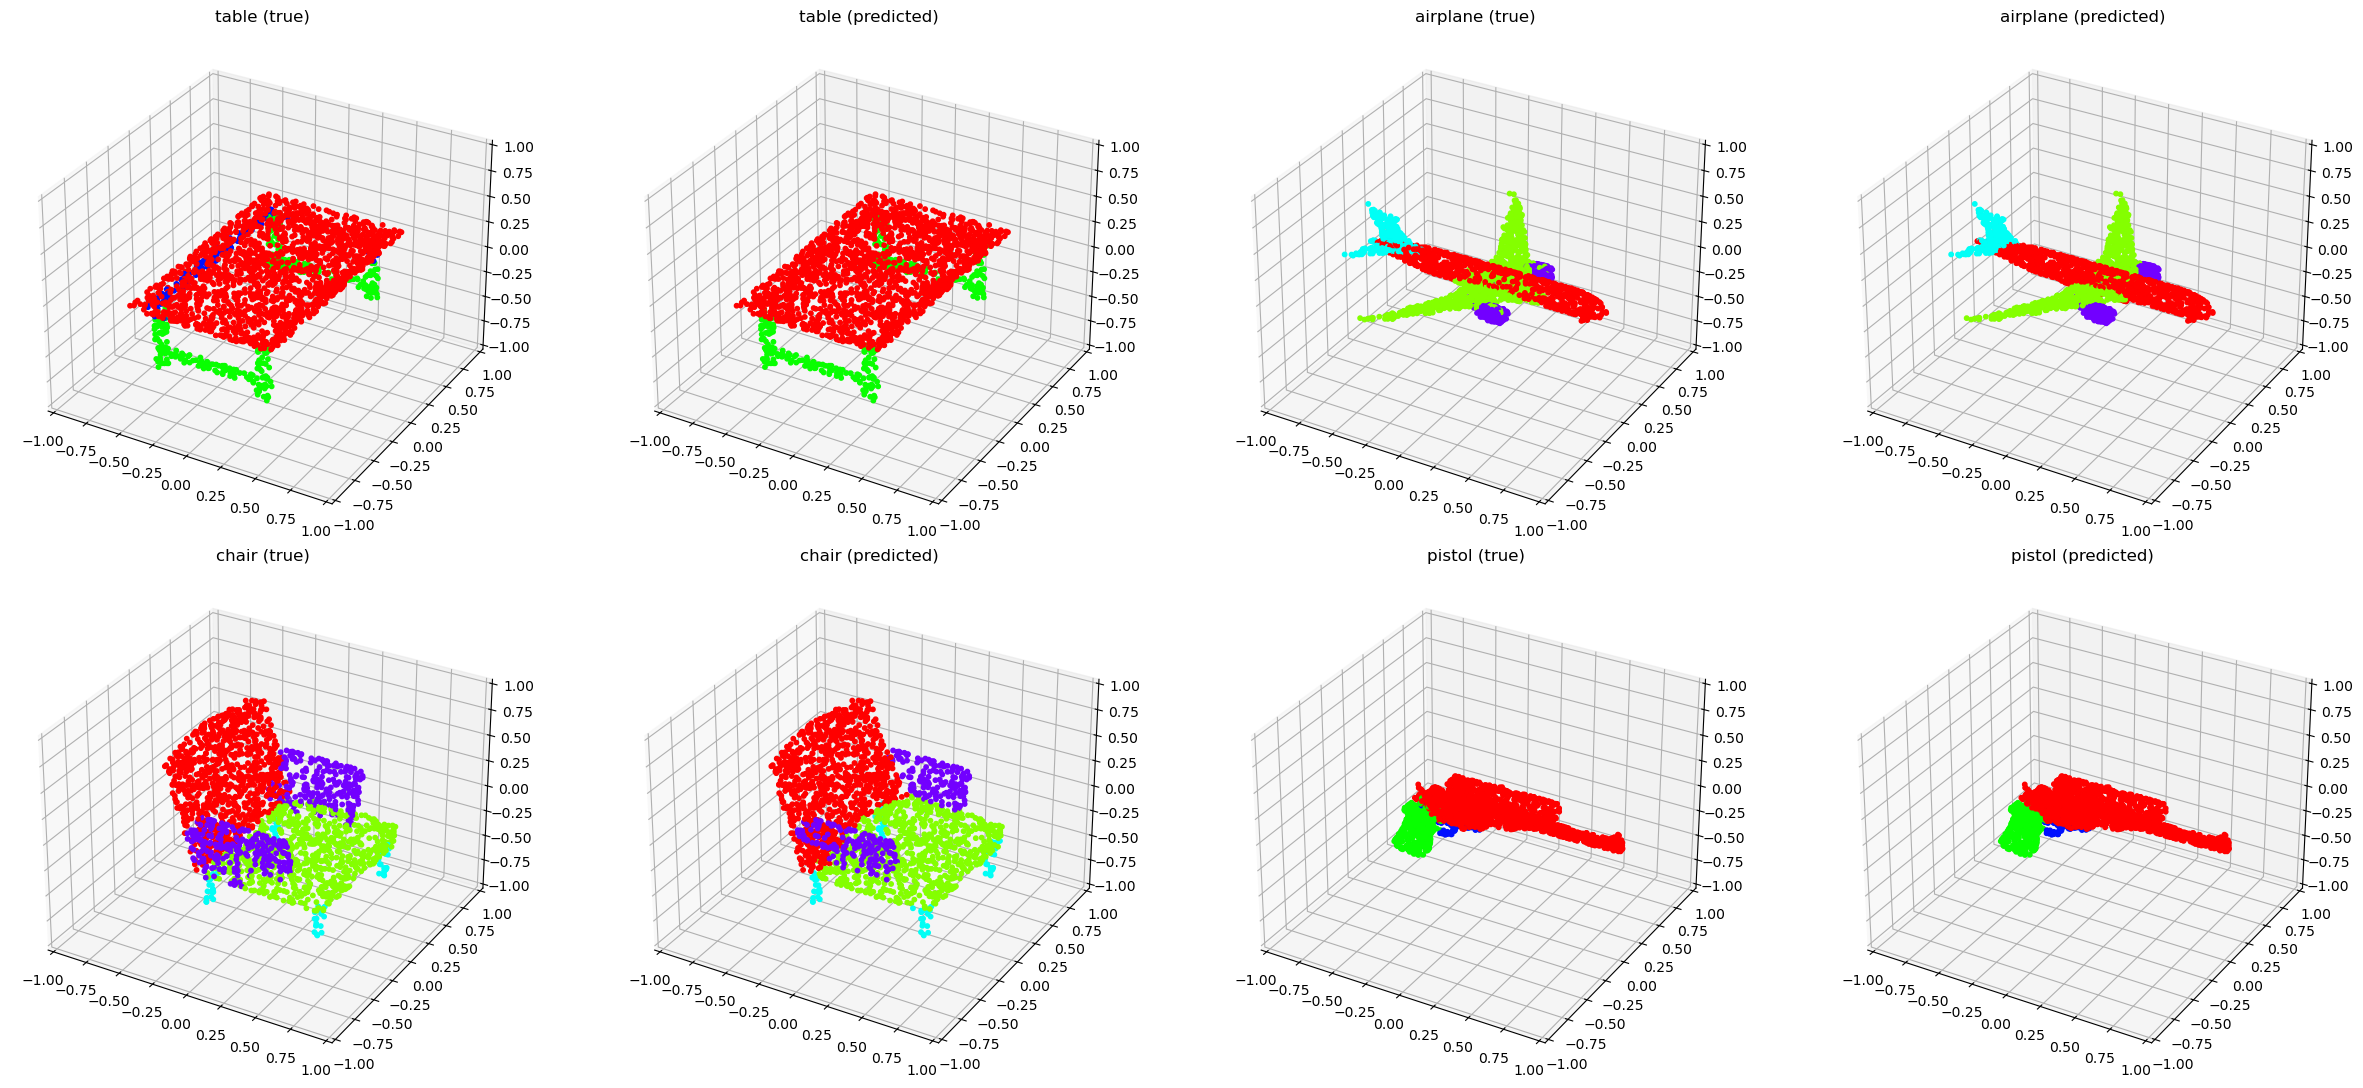

In [84]:
def segment():
    id2cat = { i: c for c,i in ShapeNetPart.cat2id.items() }
    val_data = DataLoader(ShapeNetPart(n_points=2048, partition='test', class_choice=None), batch_size=100, num_workers=4, shuffle=False, pin_memory=True)
    val_data_iter = iter(val_data)
    x,cls,y = next(val_data_iter)
    logits = net(rearrange(x, 'b n d -> b d n')).detach()
    adj_logits = net.adjust_logits2(logits)
    y_pred = adj_logits.argmax(1)
    cmap = plt.get_cmap("hsv")
    def plt_shape(ax, i, y, variant):
        points = x[i]
        parts = ShapeNetPart.cls2parts[cls[i].item()]
        seg = (y[i] - min(*parts)) / len(parts)
        ax.set_title(id2cat[cls[i].item()] + " (" + variant + ")")
        ax.scatter(points[:,0], points[:,2], points[:,1], color=cmap(seg), s=10, alpha=1)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_zlim(-1, 1)
    #ax._axis3don = False
    plt.rcParams["figure.figsize"] = (30,14)
    ax = plt.gcf().add_subplot(241, projection='3d')
    plt_shape(ax, 1, y, "true")
    ax = plt.gcf().add_subplot(242, projection='3d')
    plt_shape(ax, 1, y_pred, "predicted")
    ax = plt.gcf().add_subplot(243, projection='3d')
    plt_shape(ax, 2, y, "true")
    ax = plt.gcf().add_subplot(244, projection='3d')
    plt_shape(ax, 2, y_pred, "predicted")
    ax = plt.gcf().add_subplot(245, projection='3d')
    plt_shape(ax, 27, y, "true")
    ax = plt.gcf().add_subplot(246, projection='3d')
    plt_shape(ax, 27, y_pred, "predicted")
    ax = plt.gcf().add_subplot(247, projection='3d')
    plt_shape(ax, 78, y, "true")
    ax = plt.gcf().add_subplot(248, projection='3d')
    plt_shape(ax, 78, y_pred, "predicted")
    plt.subplots_adjust(hspace=0)
    
segment()